This file is to analysis the eigvals 

In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm, trange
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
%matplotlib inline

In [3]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Some fns

In [4]:
def load_pkl(fil):
    with open(fil, "rb") as f:
        result = pickle.load(f)
    return result

In [5]:
def CI95(cur_fs):
    mean_v, se_v = np.mean(cur_fs), np.std(cur_fs)/np.sqrt(len(cur_fs))
    low, up = mean_v - 1.96*se_v, mean_v + 1.96*se_v
    return [low, up]

In [6]:
def plot_res(fs_AD, fs_Ctrl):
    res = ss.ttest_ind(fs_AD, fs_Ctrl, equal_var=False)
    plt.figure(figsize=[10, 5])
    sns.kdeplot(fs_AD, label="AD")
    sns.kdeplot(fs_Ctrl, label="Ctrl")
    plt.legend()
    plt.title(f"Pval {res.pvalue:.4f}")

## Load results

In [7]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [8]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)
    
    
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]

In [9]:
# Eigvals for Ymat, only 88
fil = list(resDir.glob("AD_*_eigValsYmat.pkl"))[0]
with open(fil, "rb") as f:
    eigValsYmatAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigValsYmat.pkl"))[0]
with open(fil, "rb") as f:
    eigValsYmatCtrl = pickle.load(f)


In [10]:
# dwell
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)
    
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]

# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

## Analysis

### Real

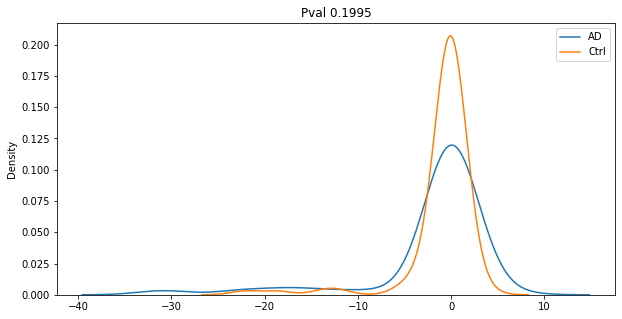

In [10]:
# real, no abs
fs_AD = [np.array(eigVal).real.mean() for eigVal in eigValsAD]
fs_Ctrl = [np.array(eigVal).real.mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)

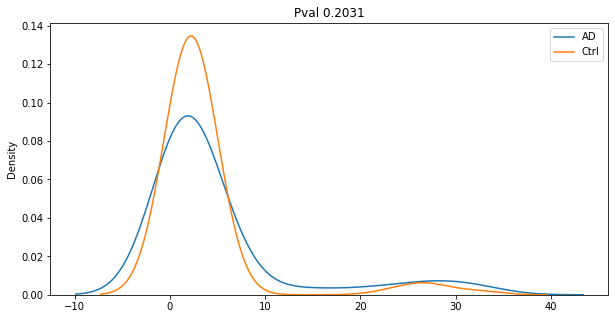

In [11]:
# real, abs
fs_AD = [np.abs(np.array(eigVal).real).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(np.array(eigVal).real).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)

7.675049824128727 [5.253389207842816, 10.096710440414636]
5.497199350108459 [3.7458640558065674, 7.24853464441035]


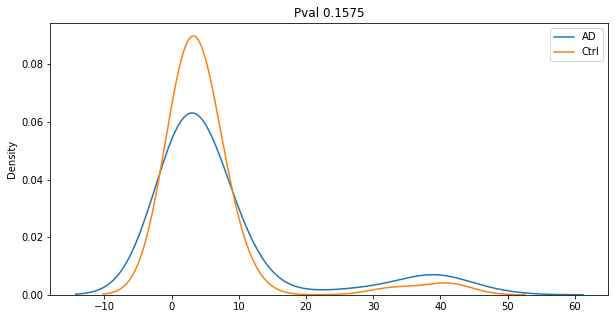

In [21]:
# real, abs, max over rank
fs_AD = [np.abs(np.array(eigVal).real).max(axis=1).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(np.array(eigVal).real).max(axis=1).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.mean(fs_AD), CI95(fs_AD))
print(np.mean(fs_Ctrl), CI95(fs_Ctrl))

### image

7.99754134411446 4.9280836328052695


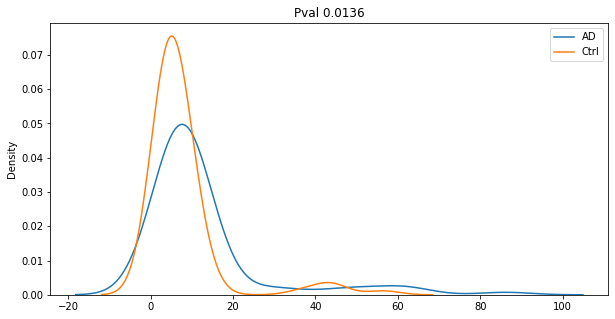

In [77]:
# max dwell 
fs_AD = []
for eigVal, dwell in zip(eigValsAD, dwellsAD):
    maxdwell_idx = np.argmax(dwell)
    eigVal_atmaxdwell = eigVal[maxdwell_idx]
    fs_AD.append(np.abs(eigVal_atmaxdwell.imag).mean())
    
fs_Ctrl = []
for eigVal, dwell in zip(eigValsCtrl, dwellsCtrl):
    maxdwell_idx = np.argmax(dwell)
    eigVal_atmaxdwell = eigVal[maxdwell_idx]
    fs_Ctrl.append(np.abs(eigVal_atmaxdwell.imag).mean())
    
plot_res(fs_AD, fs_Ctrl)
print(np.mean(fs_AD)*2/np.pi, np.mean(fs_Ctrl)*2/np.pi)

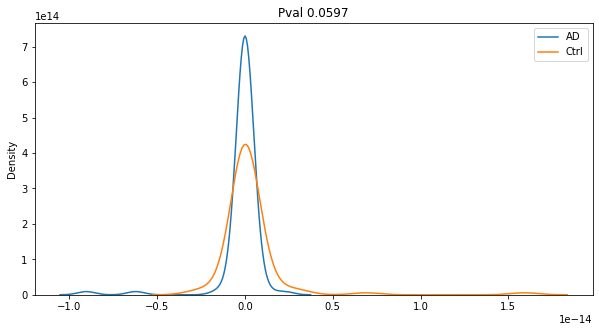

In [13]:
# imag, no abs
fs_AD = [np.array(np.array(eigVal).imag).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.array(np.array(eigVal).imag).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)

8.558585444572614 5.082244959542504


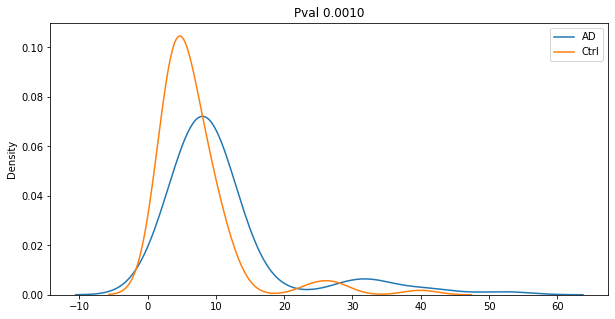

In [74]:
# imag, abs
fs_AD = [np.abs(np.array(eigVal).imag).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(np.array(eigVal).imag).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.median(fs_AD), np.median(fs_Ctrl))

50.613699756969936 20.706561391806595


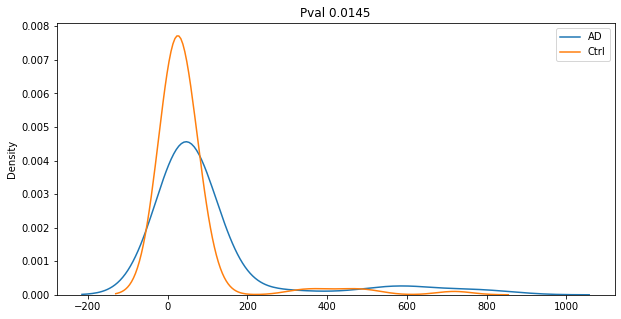

In [37]:
# imag, abs, sum over rank
fs_AD = [np.abs(np.array(eigVal).imag).sum(axis=1).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(np.array(eigVal).imag).sum(axis=1).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.median(fs_AD), np.median(fs_Ctrl))

10.18294079040229 8.180966935670227


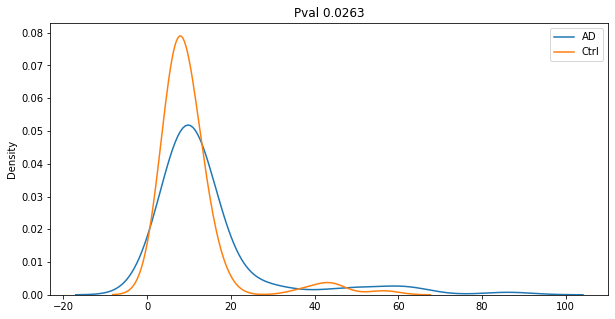

In [54]:
fs_AD = [np.abs(np.array(eigVal).imag).mean(axis=1).max() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(np.array(eigVal).imag).mean(axis=1).max() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.median(fs_AD), np.median(fs_Ctrl))

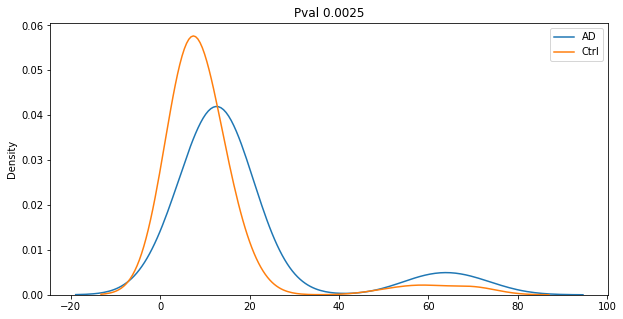

In [23]:
# imag, abs, max over rank
fs_AD = [np.abs(np.array(eigVal).imag).max(axis=1).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(np.array(eigVal).imag).max(axis=1).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)

17.899414396703396 10.911514006866327


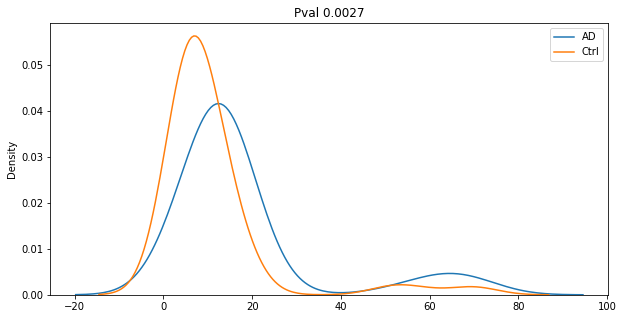

In [71]:
# imag, abs, max over rank, median
fs_AD = [np.median(np.abs(np.array(eigVal).imag).max(axis=1)) for eigVal in eigValsAD]
fs_Ctrl = [np.median(np.abs(np.array(eigVal).imag).max(axis=1)) for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.mean(fs_AD), np.mean(fs_Ctrl))

10.662041588423907 6.689829103292521


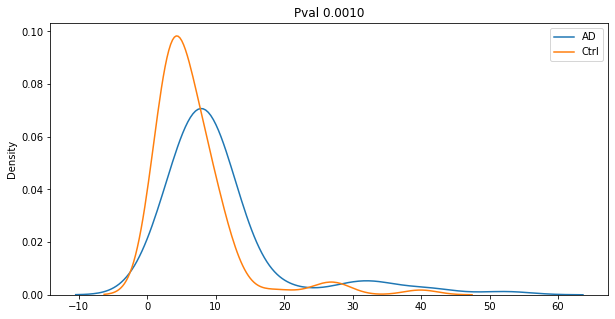

In [70]:
# imag, abs, max over rank, median
fs_AD = [np.median(np.abs(np.array(eigVal).imag).mean(axis=1)) for eigVal in eigValsAD]
fs_Ctrl = [np.median(np.abs(np.array(eigVal).imag).mean(axis=1)) for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.mean(fs_AD), np.mean(fs_Ctrl))

10.473219521463976 6.575907946622643


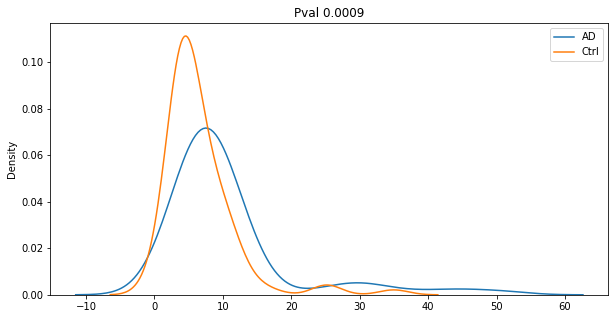

In [72]:
# imag, abs, max over rank, median
fs_AD = [np.median(np.abs(np.array(eigVal).imag), axis=1).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.median(np.abs(np.array(eigVal).imag), axis=1).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.mean(fs_AD), np.mean(fs_Ctrl))

### Both

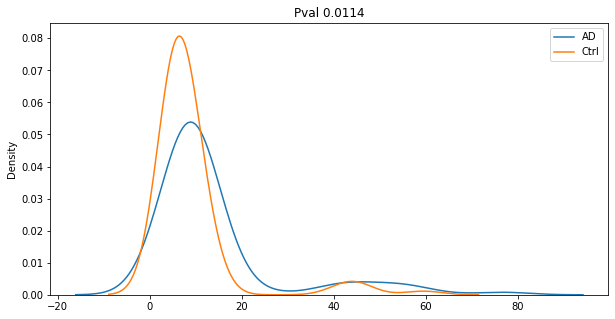

In [17]:
# all, abs
fs_AD = [np.abs(eigVal).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(eigVal).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)

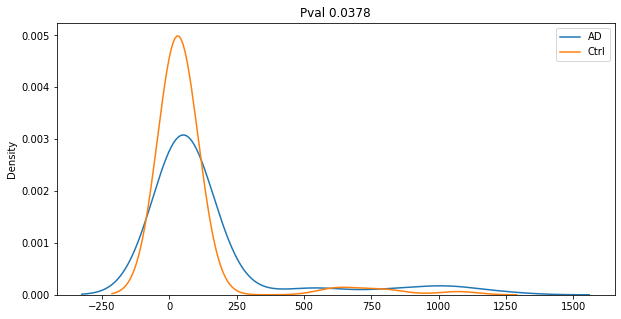

In [18]:
# all, abs, sum over rank first
fs_AD = [np.abs(eigVal).sum(axis=1).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(eigVal).sum(axis=1).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)

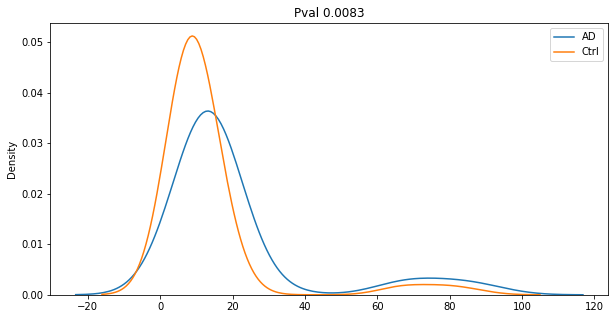

In [19]:
# all, abs, sum over rank first
fs_AD = [np.abs(eigVal).max(axis=1).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(eigVal).max(axis=1).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)

## Analysis on eigVals for Ymat

21.73970332561183 12.335947581173741


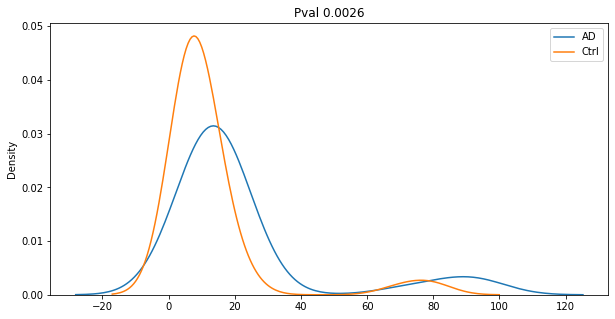

In [29]:
_imagmaxmean_fn = lambda x: np.abs(np.array(x).imag).max(axis=0).mean()
fs_AD = [_imagmaxmean_fn(eigVal) for eigVal in eigValsYmatAD]
fs_Ctrl = [_imagmaxmean_fn(eigVal) for eigVal in eigValsYmatCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.mean(fs_AD), np.mean(fs_Ctrl))

2.9168664168858394 1.7889027828470832


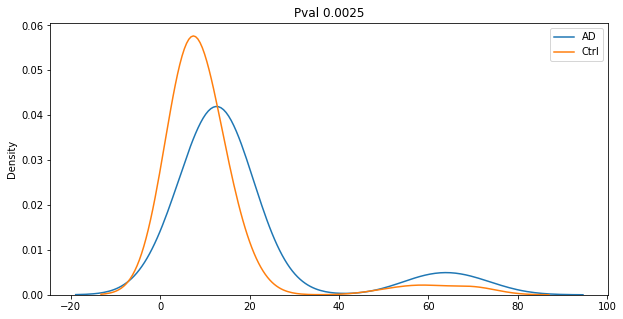

In [33]:
# imag, abs, max over rank
fs_AD = [np.abs(np.array(eigVal).imag).max(axis=1).mean() for eigVal in eigValsAD]
fs_Ctrl = [np.abs(np.array(eigVal).imag).max(axis=1).mean() for eigVal in eigValsCtrl]
plot_res(fs_AD, fs_Ctrl)
print(np.mean(fs_AD)/2/np.pi, np.mean(fs_Ctrl)/2/np.pi)